In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import count
from scipy import ndimage
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm
import tensorflow_addons as tfa

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 9999
IMAGE_SIZE = 32
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_augment"
PATH = ""

# Set seeds

In [0]:
np.random.seed(3)
tf.random.set_seed(3)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#x_train = preprocess(x_train)
#x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

# Model

In [0]:
def CIFARmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(inputs)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Data augmentation functions


In [0]:
def flip_image(image):
    if np.random.rand() < 0.2:
        image = tf.image.flip_left_right(image)
    return image

In [0]:
def rotate_image(image):
    if np.random.rand() < 0.2:
        angles = np.linspace(1,10,10)
        rotation_angle = np.random.choice(angles)
        if np.random.rand() < 0.5:
            image = ndimage.rotate(image, rotation_angle, reshape = False)
        else:
            image = ndimage.rotate(image, -rotation_angle, reshape = False) 
    return image

In [0]:
def horizontal_shift(image):
    if np.random.rand() < 0.2:
        num_rows, num_cols = image.shape[:2]
        if np.random.rand() < 0.5:
            translation_matrix = np.float32([ [1,0,3], [0,1,0] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            #image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        else:
            translation_matrix = np.float32([ [1,0,-3], [0,1,0] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            #image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
    return image

In [0]:
def vertical_shift(image):
    if np.random.rand() < 0.2:
        num_rows, num_cols = image.shape[:2]
        if np.random.rand() < 0.5:
            translation_matrix = np.float32([ [1,0,0], [0,1,2] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            #image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
        else:
            translation_matrix = np.float32([ [1,0,0], [0,1,-2] ])
            image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
            #image = image.reshape((IMAGE_SIZE,IMAGE_SIZE,1))
    return image

In [0]:
funcs = [rotate_image,
         horizontal_shift, 
         vertical_shift]

# Train

In [16]:
models = []
accuracies = [0]

for i in range(len(funcs)):

    print(f"Train model {i}")

    preprocessing_function = funcs[i]
    datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
    datagen = datagen.flow(x_train,y_train, batch_size = BATCH_SIZE)

    model = CIFARmodel(IMAGE_SIZE, NUM_CLASSES, 3)

    es = EarlyStopping(min_delta = 0.01, patience=3, restore_best_weights=True)
    model.fit_generator(datagen,
                        epochs = EPOCHS,
                        validation_data = (x_val,y_val),
                        shuffle = True,
                        callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    delta = acc - accuracies[-1]

    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")

Train model 0
Epoch 1/9999
313/313 [==============================] - 16s 52ms/step - loss: 1.7116 - accuracy: 0.3924 - val_loss: 2.2424 - val_accuracy: 0.1326
Epoch 2/9999
313/313 [==============================] - 9s 30ms/step - loss: 1.3540 - accuracy: 0.5195 - val_loss: 1.4919 - val_accuracy: 0.4826
Epoch 3/9999
313/313 [==============================] - 9s 29ms/step - loss: 1.2060 - accuracy: 0.5743 - val_loss: 1.2085 - val_accuracy: 0.5711
Epoch 4/9999
313/313 [==============================] - 9s 29ms/step - loss: 1.0916 - accuracy: 0.6173 - val_loss: 1.1709 - val_accuracy: 0.5819
Epoch 5/9999
313/313 [==============================] - 9s 30ms/step - loss: 1.0038 - accuracy: 0.6496 - val_loss: 1.1324 - val_accuracy: 0.5973
Epoch 6/9999
313/313 [==============================] - 9s 29ms/step - loss: 0.9341 - accuracy: 0.6770 - val_loss: 1.0444 - val_accuracy: 0.6275
Epoch 7/9999
313/313 [==============================] - 9s 30ms/step - loss: 0.8715 - accuracy: 0.7017 - val_loss: 

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Model: 0 added. Resulting score: 0.6643
Train model 1
Epoch 1/9999
313/313 [==============================] - 7s 22ms/step - loss: 1.7512 - accuracy: 0.3825 - val_loss: 2.2899 - val_accuracy: 0.1251
Epoch 2/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.3777 - accuracy: 0.5148 - val_loss: 1.5093 - val_accuracy: 0.4789
Epoch 3/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.2174 - accuracy: 0.5725 - val_loss: 1.2459 - val_accuracy: 0.5531
Epoch 4/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.1123 - accuracy: 0.6101 - val_loss: 1.1543 - val_accuracy: 0.5894
Epoch 5/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.0309 - accuracy: 0.6395 - val_loss: 1.0966 - val_accuracy: 0.6144
Epoch 6/9999
313/313 [==============================] - 6s 20ms/step - loss: 0.9610 - accuracy: 0.6658 - val_loss: 1.0550 - val_accuracy: 0.6263
Epoch 7/9999
313/313 [==============================] - 6s 20ms/step - loss:

100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


Model: 1 added. Resulting score: 0.6669
Train model 2
Epoch 1/9999
313/313 [==============================] - 7s 22ms/step - loss: 1.7258 - accuracy: 0.3886 - val_loss: 2.1879 - val_accuracy: 0.1495
Epoch 2/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.3504 - accuracy: 0.5224 - val_loss: 1.4086 - val_accuracy: 0.5206
Epoch 3/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.1953 - accuracy: 0.5798 - val_loss: 1.1870 - val_accuracy: 0.5812
Epoch 4/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.0871 - accuracy: 0.6198 - val_loss: 1.1451 - val_accuracy: 0.5960
Epoch 5/9999
313/313 [==============================] - 6s 20ms/step - loss: 1.0113 - accuracy: 0.6479 - val_loss: 1.1416 - val_accuracy: 0.6029
Epoch 6/9999
313/313 [==============================] - 6s 20ms/step - loss: 0.9426 - accuracy: 0.6730 - val_loss: 1.1391 - val_accuracy: 0.5987
Epoch 7/9999
313/313 [==============================] - 6s 20ms/step - loss:

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

Model: 2 added. Resulting score: 0.7048


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensemble

In [17]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.0000,0
1,0.6643,1
2,0.6669,2
3,0.7048,3


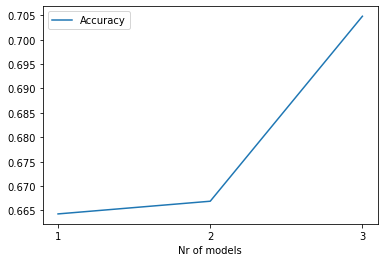

In [18]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [19]:
print("Accuracy: " + str(predict(models, x_test, y_test)))

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

Accuracy: 0.6938


In [20]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))



100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


## Correlation between models

In [21]:
classified = []

for prediction in tqdm(predictions):
    classified.append([1 if i==j else 0 for i,j in zip(prediction,np.argmax(y_test, axis = 1))])

100%|██████████| 3/3 [00:00<00:00, 251.48it/s]


In [22]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

,0,1,2
0,NaN,0.657635,0.688520
1,0.657635,NaN,0.701254
2,0.688520,0.701254,NaN


Average correlation: 0.6824696316410984
